In [103]:
%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [104]:
import os
import warnings
warnings.filterwarnings('ignore')
os.environ["PYTHONWARNINGS"] = "ignore"

In [105]:
cur_folder_name = os.getcwd().split('/')[-1]
if cur_folder_name != "fairness-variance":
    os.chdir("../..")

print('Current location: ', os.getcwd())

Current location:  c:\


# Visualizations

In [106]:
import os
import numpy as np
import pandas as pd

from virny.utils.custom_initializers import create_models_metrics_dct_from_database_df

from source.utils.db_functions import read_model_metric_dfs_from_db
from source.custom_classes.experiments_composer import ExperimentsComposer
from source.custom_classes.experiments_visualizer import ExperimentsVisualizer

from virny.utils.custom_initializers import create_models_metrics_dct_from_database_df

from source.visualizations import preprocess_metrics, create_group_base_and_fair_models_box_plot, \
    create_scatter_plot, create_group_models_box_plot_per_test_set, create_bar_plot_for_model_selection

## Initialize Configs

In [107]:
#DB_COLLECTION_NAME = 'bootstrap_sizes_experiment'
DB_COLLECTION_NAME = 'eq_odds_postprocessing_new'
DATASET_NAME = 'ACSIncome'

EXPERIMENTS_SESSION_UUID = {
    "0.8": "6c1ea468-8164-4e68-9ca2-129bc5e23424",
    "0.5": "f4cfb252-9282-4590-af0d-eb9fdc8e2e09",
    "0.2": "094a4224-8bb1-4499-9d63-88cbdcff9cf7"
}

SENSITIVE_ATTRS = ['SEX', 'RAC1P', 'SEX&RAC1P']
MODEL_NAMES = ['RandomForestClassifier']

In [108]:
from source.utils.db_functions import connect_to_mongodb

client, collection_obj, db_writer_func = connect_to_mongodb(DB_COLLECTION_NAME)

## Group Metrics Composition

### Boostrap_size = 0.8

In [109]:
model_metric_dfs = read_model_metric_dfs_from_db(collection_obj, EXPERIMENTS_SESSION_UUID["0.8"])
models_metrics_dct = create_models_metrics_dct_from_database_df(model_metric_dfs)
client.close()

In [110]:
for model_name in models_metrics_dct.keys():
    models_metrics_dct[model_name]['Test_Set_Index'] = 0

In [111]:
df = models_metrics_dct[list(models_metrics_dct.keys())[0]]
df[(df.Metric == 'Label_Stability')].T

,60,61,62,63,64,65,66,67,68,69
Metric,Label_Stability,Label_Stability,Label_Stability,Label_Stability,Label_Stability,Label_Stability,Label_Stability,Label_Stability,Label_Stability,Label_Stability
Model_Name,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier,RandomForestClassifier
Model_Params,"{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w...","{'bootstrap': True, 'ccp_alpha': 0.0, 'class_w..."
Dataset_Name,Folktables_GA_2018_Income,Folktables_GA_2018_Income,Folktables_GA_2018_Income,Folktables_GA_2018_Income,Folktables_GA_2018_Income,Folktables_GA_2018_Income,Folktables_GA_2018_Income,Folktables_GA_2018_Income,Folktables_GA_2018_Income,Folktables_GA_2018_Income
Num_Estimators,200,200,200,200,200,200,200,200,200,200
Tag,OK,OK,OK,OK,OK,OK,OK,OK,OK,OK
Record_Create_Date_Time,2023-12-06 21:00:50.548000,2023-12-06 21:24:07.085000,2023-12-06 21:01:49.615000,2023-12-06 21:24:59.121000,2023-12-06 20:54:42.746000,2023-12-06 21:13:14.244000,2023-12-06 21:02:31.388000,2023-12-06 21:26:34.809000,2023-12-06 21:00:15.907000,2023-12-06 21:23:29.357000
Session_Uuid,6c1ea468-8164-4e68-9ca2-129bc5e23424,6c1ea468-8164-4e68-9ca2-129bc5e23424,6c1ea468-8164-4e68-9ca2-129bc5e23424,6c1ea468-8164-4e68-9ca2-129bc5e23424,6c1ea468-8164-4e68-9ca2-129bc5e23424,6c1ea468-8164-4e68-9ca2-129bc5e23424,6c1ea468-8164-4e68-9ca2-129bc5e23424,6c1ea468-8164-4e68-9ca2-129bc5e23424,6c1ea468-8164-4e68-9ca2-129bc5e23424,6c1ea468-8164-4e68-9ca2-129bc5e23424
Experiment_Iteration,Exp_iter_1,Exp_iter_1,Exp_iter_2,Exp_iter_2,Exp_iter_3,Exp_iter_3,Exp_iter_4,Exp_iter_4,Exp_iter_5,Exp_iter_5
Dataset_Split_Seed,100,100,200,200,300,300,400,400,500,500


In [112]:
exp_composer = ExperimentsComposer(models_metrics_dct, SENSITIVE_ATTRS)
exp_subgroup_metrics_dct = exp_composer.create_exp_subgroup_metrics_dct_for_mult_test_sets()

In [113]:
exp_group_metrics_dct = exp_composer.compose_group_metrics_for_mult_test_sets(exp_subgroup_metrics_dct)

In [114]:
melted_all_subgroup_metrics_per_model_dct, melted_all_group_metrics_per_model_dct = \
    preprocess_metrics(exp_subgroup_metrics_dct, exp_group_metrics_dct)

In [115]:
test_df = melted_all_subgroup_metrics_per_model_dct["RandomForestClassifier"]
test_df[(test_df['Metric'] == 'Label_Stability') & (test_df["Subgroup"] == 'overall')][["Experiment_Iteration", "Intervention_Param", "Metric", "Metric_Value"]].sort_values(["Intervention_Param", "Experiment_Iteration"])

,Experiment_Iteration,Intervention_Param,Metric,Metric_Value
331,Exp_iter_1,0.0,Label_Stability,0.898300
331,Exp_iter_2,0.0,Label_Stability,0.898707
331,Exp_iter_3,0.0,Label_Stability,0.905227
331,Exp_iter_4,0.0,Label_Stability,0.909047
331,Exp_iter_5,0.0,Label_Stability,0.904240
221,Exp_iter_1,1.0,Label_Stability,0.877440
221,Exp_iter_2,1.0,Label_Stability,0.877147
221,Exp_iter_3,1.0,Label_Stability,0.884113
221,Exp_iter_4,1.0,Label_Stability,0.886540
221,Exp_iter_5,1.0,Label_Stability,0.883187


In [116]:
melted_all_subgroup_metrics_per_model_dct['RandomForestClassifier']["Intervention_Param"]= melted_all_subgroup_metrics_per_model_dct['RandomForestClassifier']["Intervention_Param"].astype(bool)

<Figure size 1200x600 with 0 Axes>

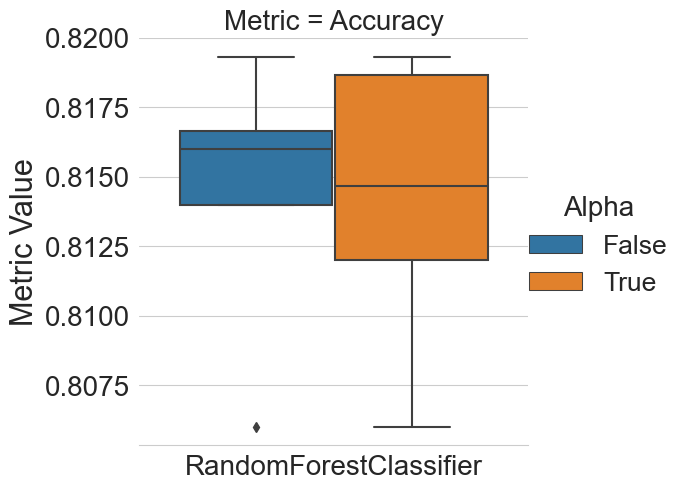

In [117]:
create_group_base_and_fair_models_box_plot(melted_all_subgroup_metrics_per_model_dct,
                                           #ylim=(0.8, 0.84),
                                           metric_names=['Accuracy'],
                                           )

<Figure size 1200x600 with 0 Axes>

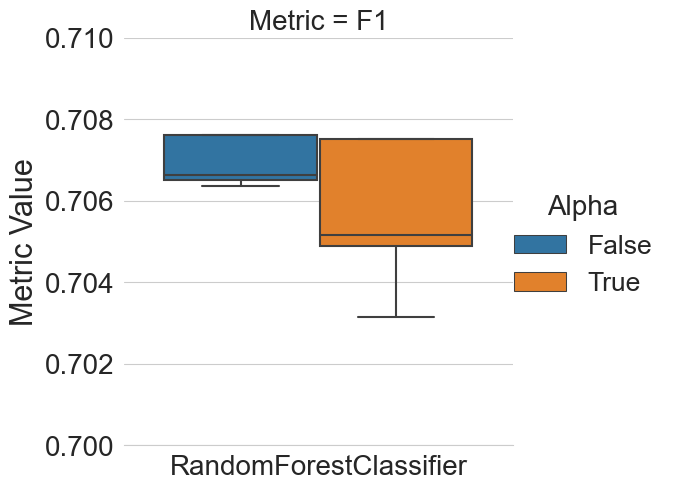

In [118]:
create_group_base_and_fair_models_box_plot(melted_all_subgroup_metrics_per_model_dct,
                                           ylim=(0.7, 0.710),
                                           metric_names=['F1'],
                                           )

<Figure size 1200x600 with 0 Axes>

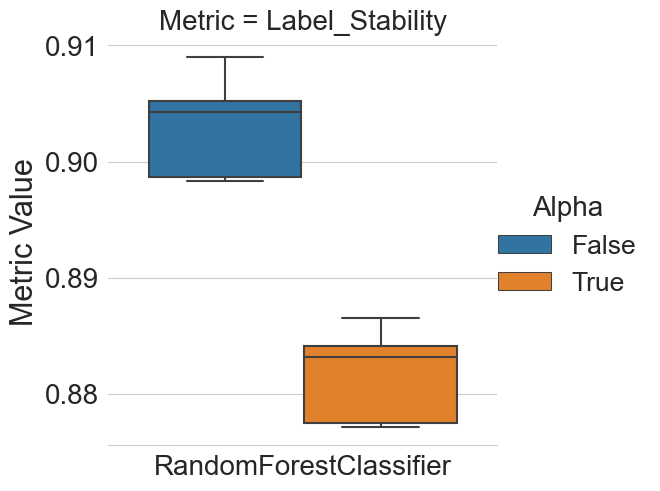

In [119]:
create_group_base_and_fair_models_box_plot(melted_all_subgroup_metrics_per_model_dct,
                                           #ylim=(0.925, 1.005),
                                           metric_names=['Label_Stability'])

<Figure size 1200x600 with 0 Axes>

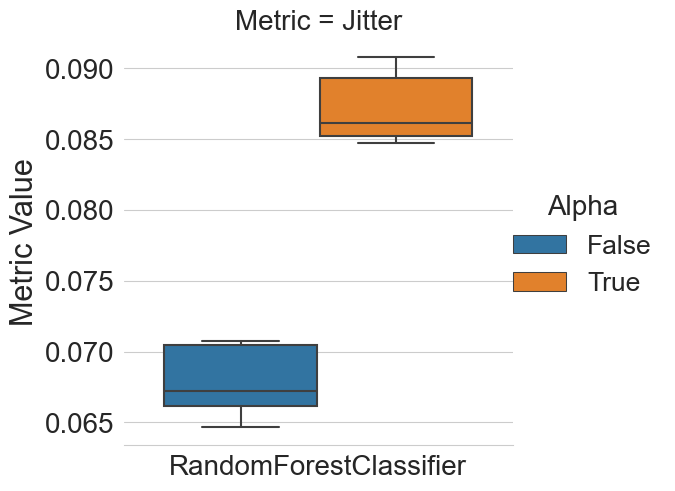

In [120]:
create_group_base_and_fair_models_box_plot(melted_all_subgroup_metrics_per_model_dct,
                                           #ylim=(0.925, 1.005),
                                           metric_names=['Jitter'])

In [121]:
test_df = melted_all_group_metrics_per_model_dct["RandomForestClassifier"]
test_df[(test_df['Metric'] == 'Equalized_Odds_FPR') & (test_df["Group"] == 'RAC1P')][["Experiment_Iteration", "Intervention_Param", "Metric", "Metric_Value"]].sort_values(["Intervention_Param", "Experiment_Iteration"])

,Experiment_Iteration,Intervention_Param,Metric,Metric_Value
21,Exp_iter_1,0.0,Equalized_Odds_FPR,-0.052827
21,Exp_iter_2,0.0,Equalized_Odds_FPR,-0.069481
21,Exp_iter_3,0.0,Equalized_Odds_FPR,-0.022516
21,Exp_iter_4,0.0,Equalized_Odds_FPR,-0.085840
21,Exp_iter_5,0.0,Equalized_Odds_FPR,-0.069413
12,Exp_iter_1,1.0,Equalized_Odds_FPR,-0.050026
12,Exp_iter_2,1.0,Equalized_Odds_FPR,-0.065591
12,Exp_iter_3,1.0,Equalized_Odds_FPR,-0.019172
12,Exp_iter_4,1.0,Equalized_Odds_FPR,-0.077630
12,Exp_iter_5,1.0,Equalized_Odds_FPR,-0.060637


In [122]:
np.median([-0.063596, -0.063410, -0.029912, -0.057925, -0.068261])

-0.06341

<AxesSubplot: >

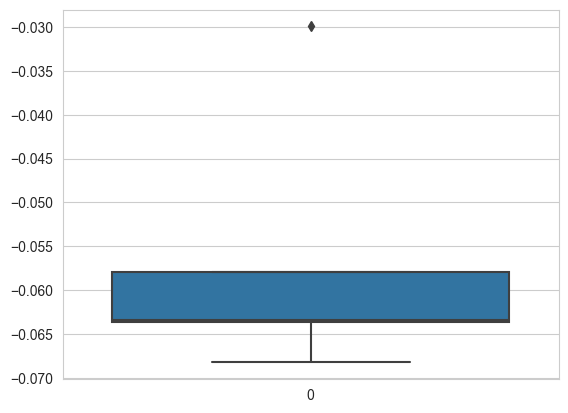

In [123]:
import seaborn as sns
sns.boxplot([-0.063596, -0.063410, -0.029912, -0.057925, -0.068261])

<Figure size 1200x600 with 0 Axes>

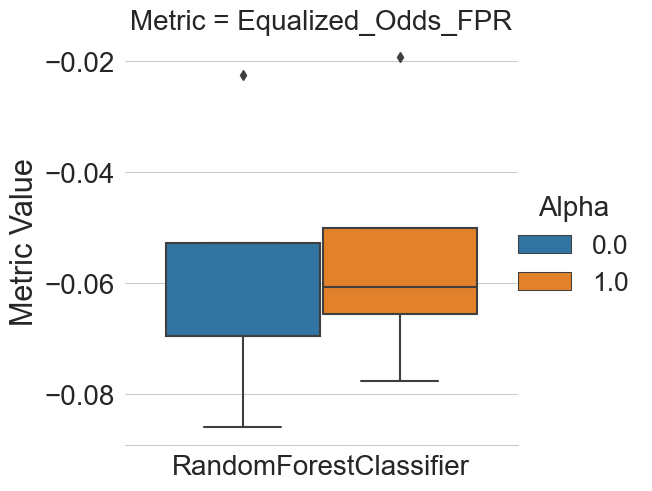

In [124]:
create_group_base_and_fair_models_box_plot(melted_all_group_metrics_per_model_dct,
                                           group='RAC1P',
                                           metric_names=['Equalized_Odds_FPR'])

<Figure size 1200x600 with 0 Axes>

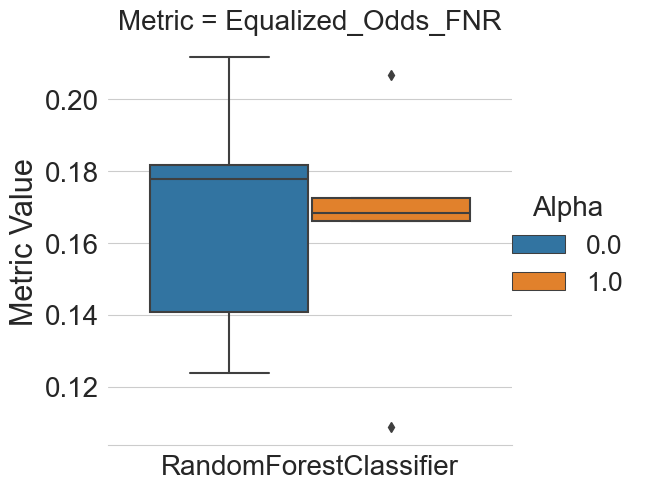

In [125]:
create_group_base_and_fair_models_box_plot(melted_all_group_metrics_per_model_dct,
                                           group='RAC1P',
                                           metric_names=['Equalized_Odds_FNR'])

<Figure size 1200x600 with 0 Axes>

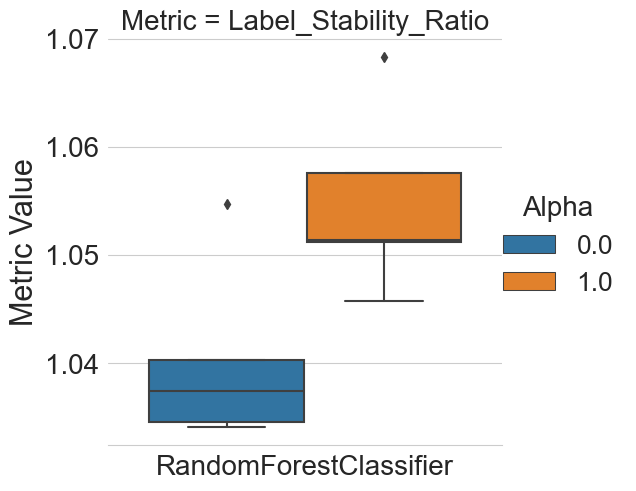

In [126]:
create_group_base_and_fair_models_box_plot(melted_all_group_metrics_per_model_dct,
                                           group='RAC1P',
                                           metric_names=['Label_Stability_Ratio'])

<Figure size 1200x600 with 0 Axes>

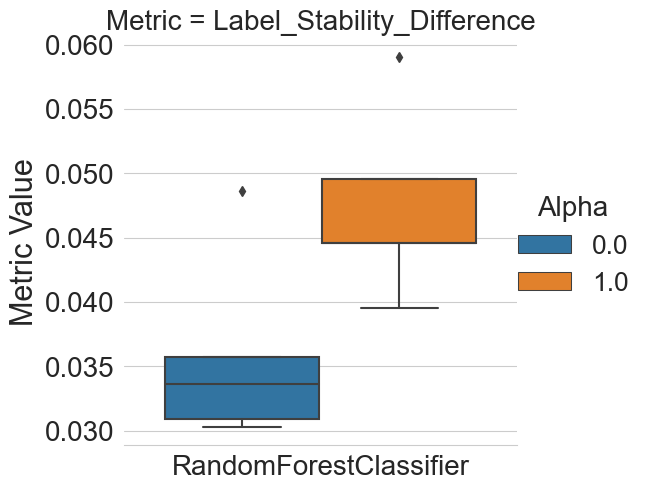

In [127]:
create_group_base_and_fair_models_box_plot(melted_all_group_metrics_per_model_dct,
                                           group='RAC1P',
                                           metric_names=['Label_Stability_Difference'])

### Analyze results from experiment with eqodds params

In [128]:
DB_COLLECTION_NAME = 'eq_odds_postprocessing_new'
DATASET_NAME = 'ACSIncome'

#EXPERIMENT_SESSION_UUID = "ff207e57-91af-4c08-bf5b-488593e0c288"
EXPERIMENTS_SESSION_UUID = {
    "0.8": "6c1ea468-8164-4e68-9ca2-129bc5e23424",
    "0.5": "f4cfb252-9282-4590-af0d-eb9fdc8e2e09",
    "0.2": "094a4224-8bb1-4499-9d63-88cbdcff9cf7"
}

SENSITIVE_ATTRS = ['SEX', 'RAC1P', 'SEX&RAC1P']
MODEL_NAMES = ['RandomForestClassifier']

In [129]:
client, collection_obj, db_writer_func = connect_to_mongodb(DB_COLLECTION_NAME)
all_sizes = []
for k in EXPERIMENTS_SESSION_UUID:
    model_metric_dfs = read_model_metric_dfs_from_db(collection_obj, EXPERIMENTS_SESSION_UUID[k])
    models_metrics_dct = create_models_metrics_dct_from_database_df(model_metric_dfs)
    
    for model_name in models_metrics_dct.keys():
        models_metrics_dct[model_name]['Test_Set_Index'] = 0
    
    exp_composer = ExperimentsComposer(models_metrics_dct, SENSITIVE_ATTRS)
    exp_subgroup_metrics_dct = exp_composer.create_exp_subgroup_metrics_dct_for_mult_test_sets()
    exp_group_metrics_dct = exp_composer.compose_group_metrics_for_mult_test_sets(exp_subgroup_metrics_dct)
    melted_all_subgroup_metrics_per_model_dct, melted_all_group_metrics_per_model_dct = \
        preprocess_metrics(exp_subgroup_metrics_dct, exp_group_metrics_dct)
    all_sizes.append(melted_all_subgroup_metrics_per_model_dct["RandomForestClassifier"])
client.close()

In [130]:
sizes = [0.8, 0.5, 0.2]
for size, subset in zip(sizes, all_sizes):
    mask = (subset['Metric'] == 'Label_Stability') & (subset["Subgroup"] == 'overall') & (subset["Intervention_Param"] == 1)
    values = subset[mask]["Metric_Value"].values
    print("Bootstrap fraction ", size)
    print(f"Label_stability mean: {np.mean(values)}, std: {np.std(values)}")

Bootstrap fraction  0.8
Label_stability mean: 0.8816853333333334, std: 0.0037507152503075056
Bootstrap fraction  0.5
Label_stability mean: 0.8664533333333333, std: 0.0051715753026627355
Bootstrap fraction  0.2
Label_stability mean: 0.8432693333333333, std: 0.005317031084689625
